In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
### General imports 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

### Custom functions
import sys
sys.path.append('../python')
from functions import *
from models import *

### ML-related
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-02-08 17:14:57.386187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-08 17:15:00.446841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-02-08 17:15:00.447772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-08 17:15:00.451223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-08 17:15:00.454315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-08 17:15:00.455193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-0

### Load the optimized tail file from a previous training

In [5]:
test = pd.read_hdf("../trained_models/foundtail_size128_batch10000_epochs2000/df_test.h5")

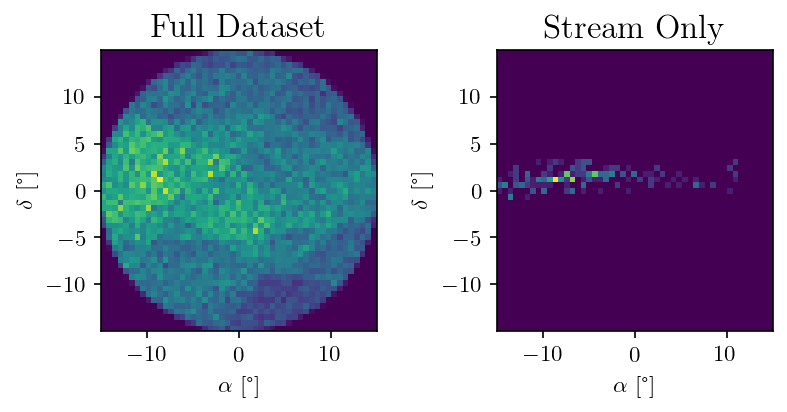

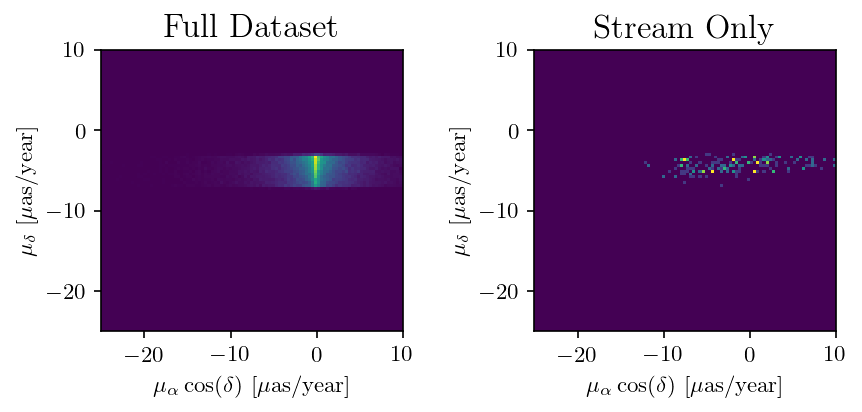

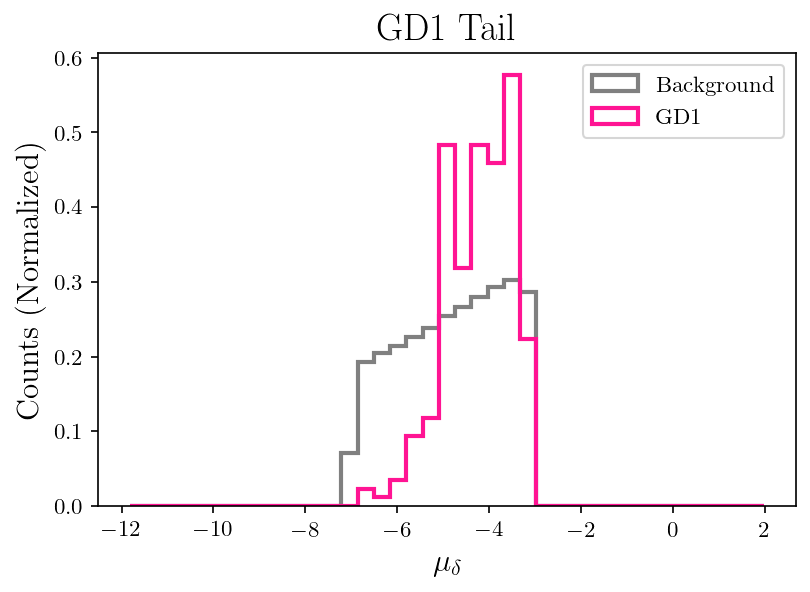

In [6]:
visualize_stream(test)

Maximum purity of 13.5% at 0.51%
Top 10 stars: Purity = 0.0% 
Top 20 stars: Purity = 0.0% 
Top 50 stars: Purity = 24.0% 
Top 100 stars: Purity = 31.0% 


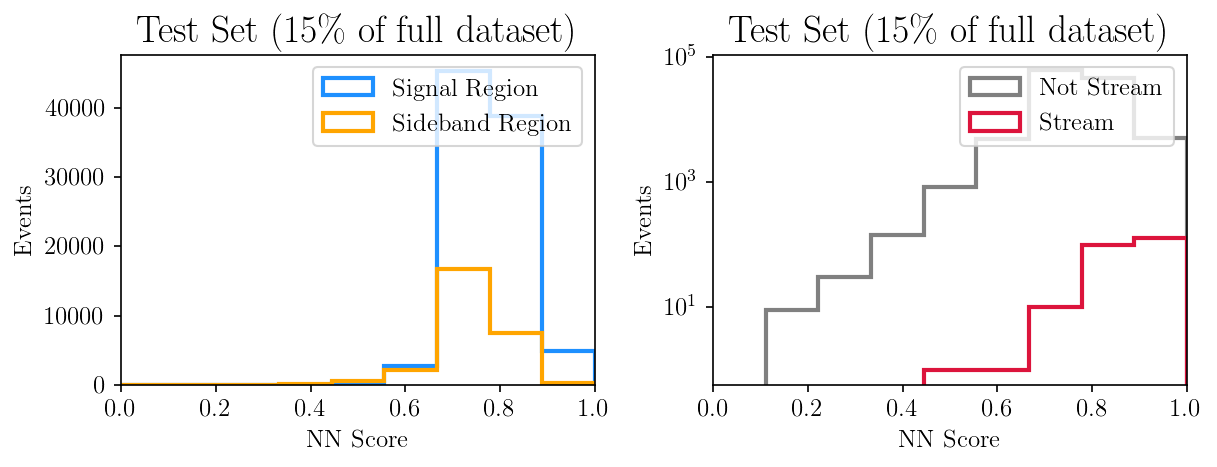

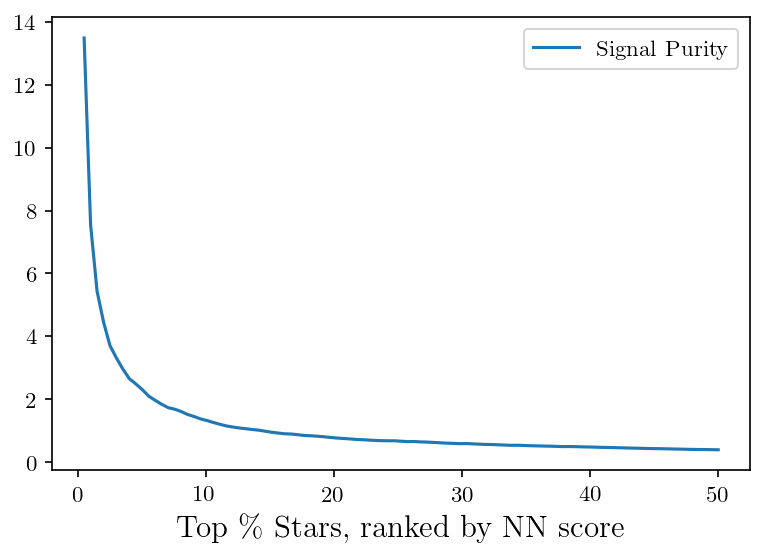

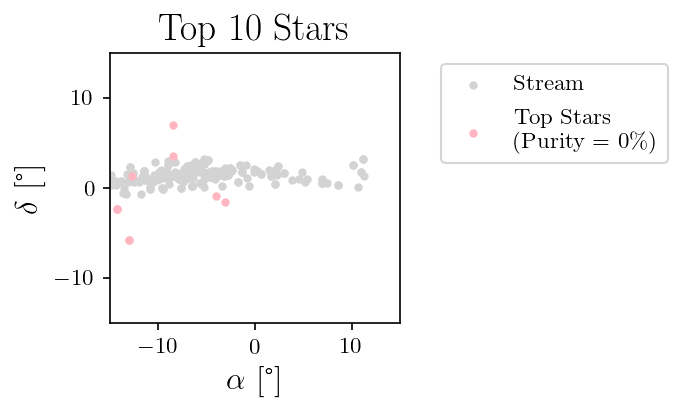

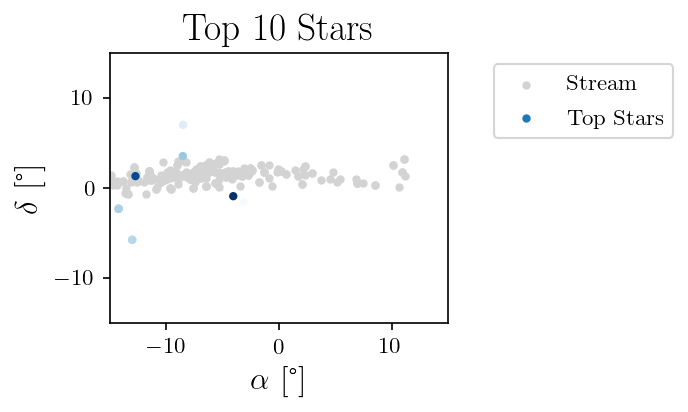

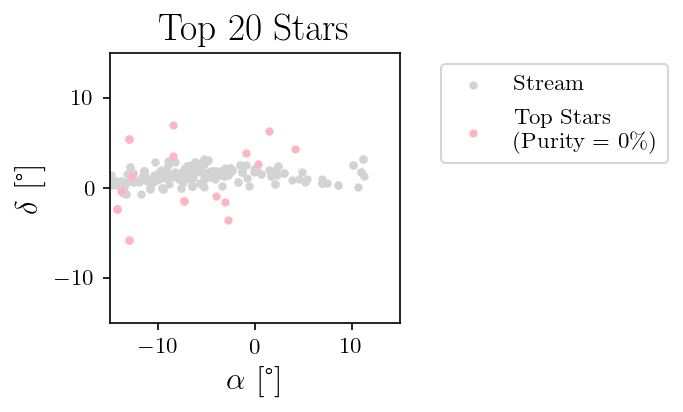

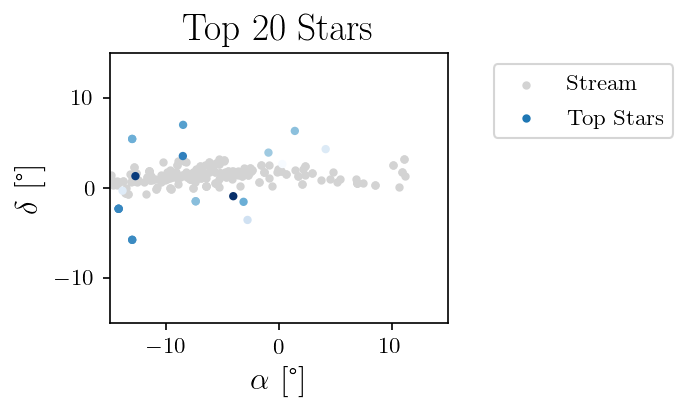

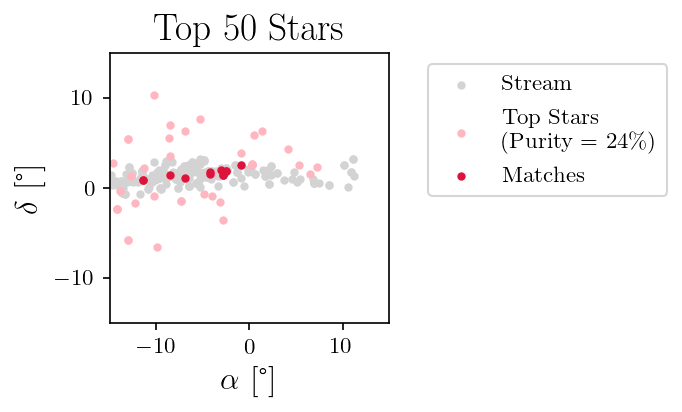

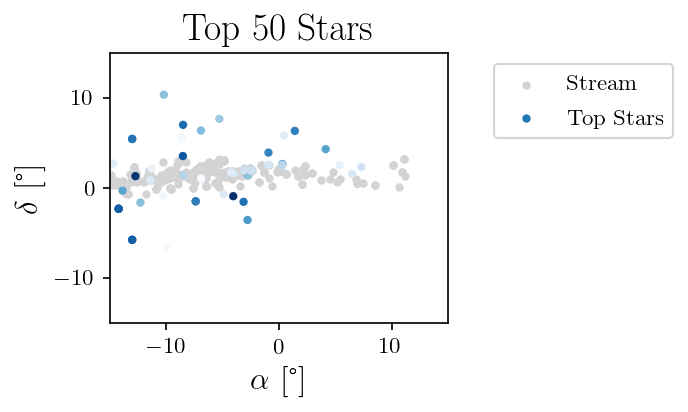

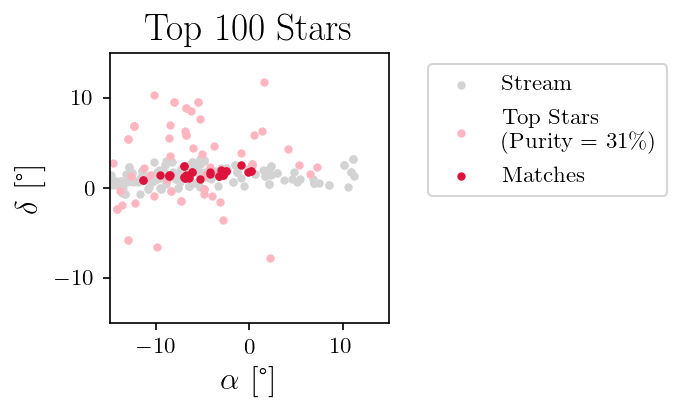

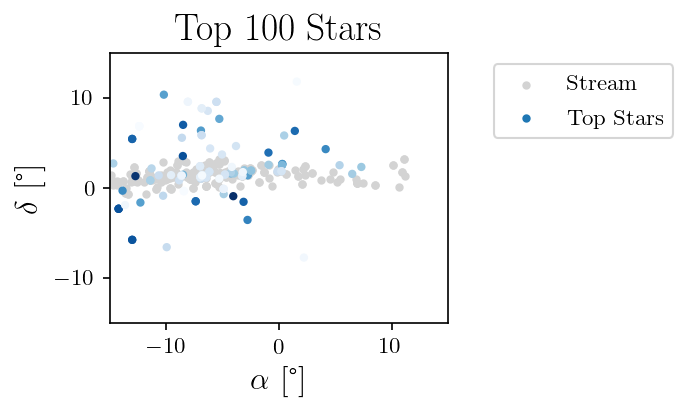

In [7]:
plot_results(test)

### Now let's investigate the stars that look plausibly stream-like but are not labeled as part of the stream

In [9]:
n_top_stars = 100
top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars] # pick the top ranked stars 

# sort by labeled and unlabeled 
labeled = top_stars[top_stars.stream]
unlabeled = top_stars[top_stars.stream == False]

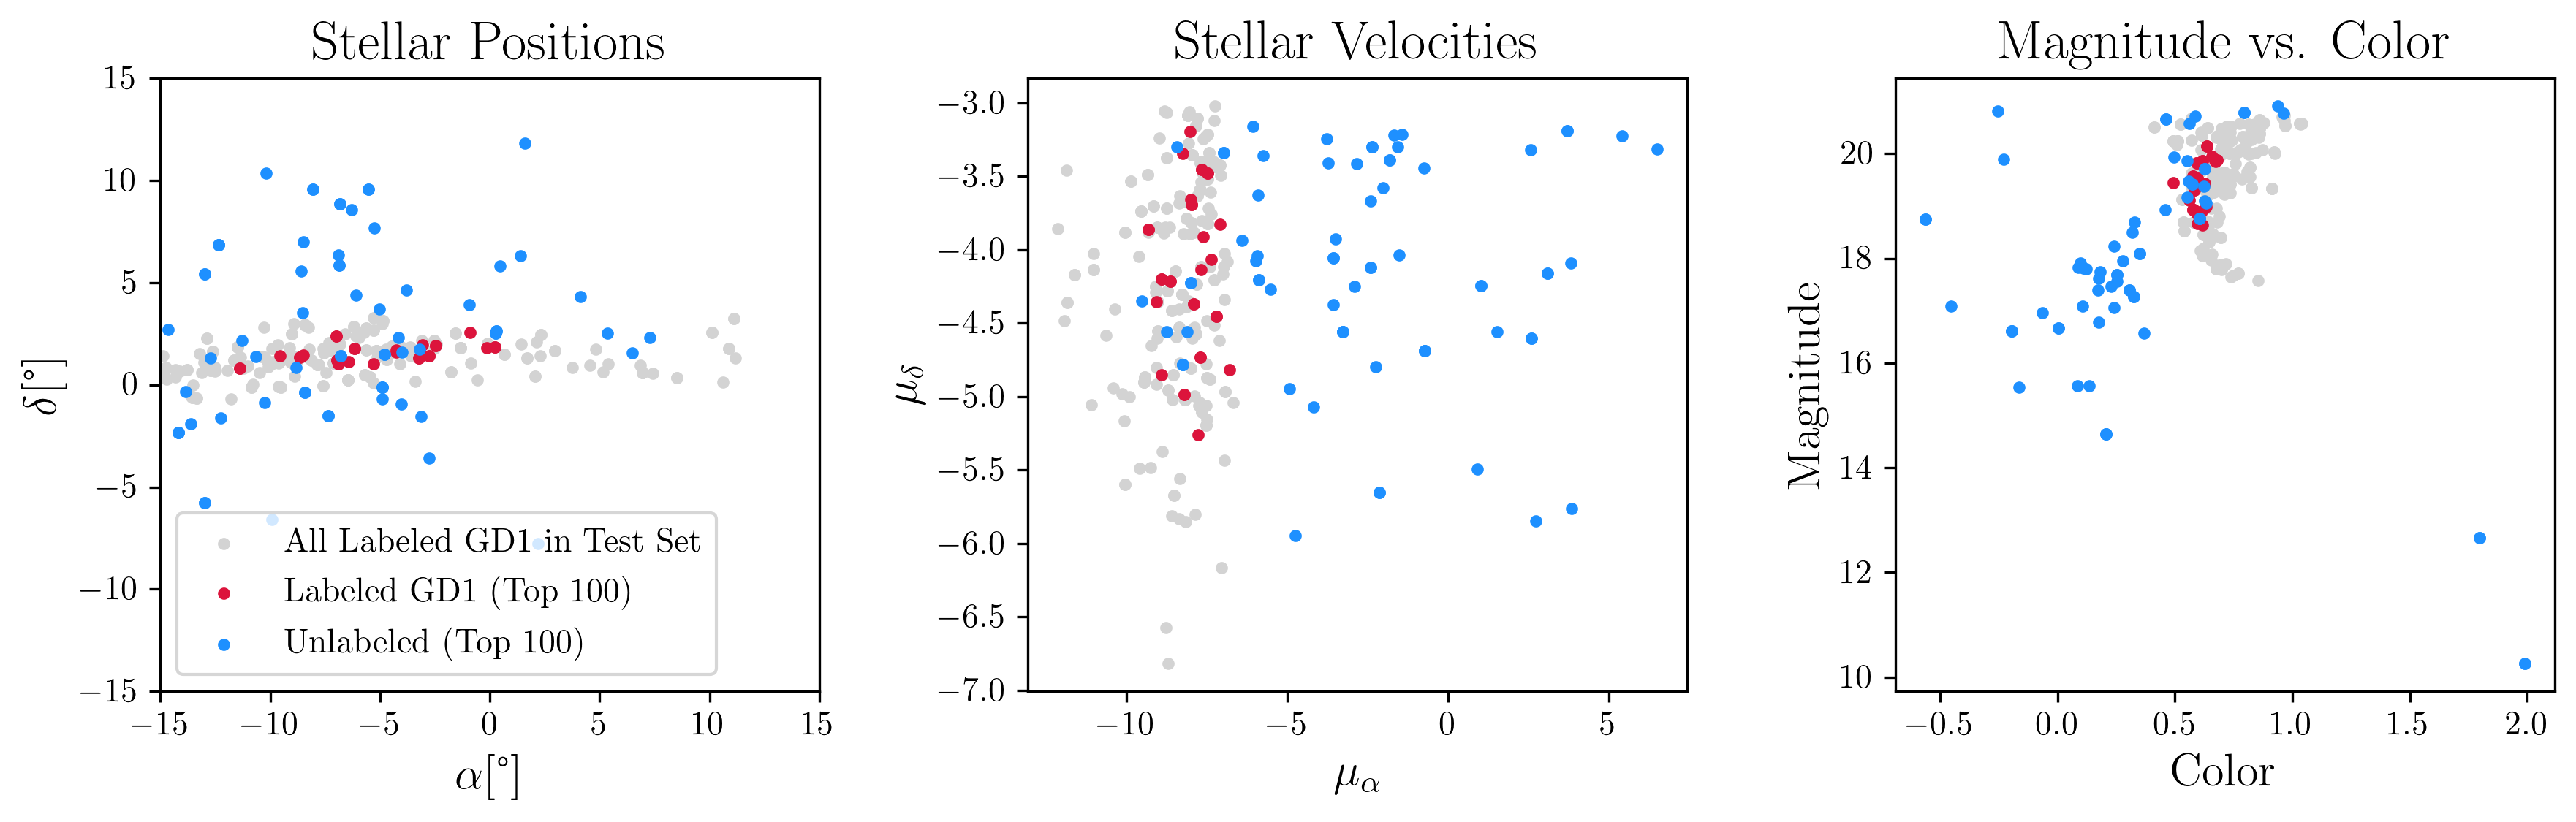

In [33]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α, test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
plt.savefig("../plots/mislabeled_triptych.png")

Isolate the unlabeled stars that look close to the stream stars in velocity space...

In [34]:
promising = unlabeled[unlabeled.μ_α < -6]

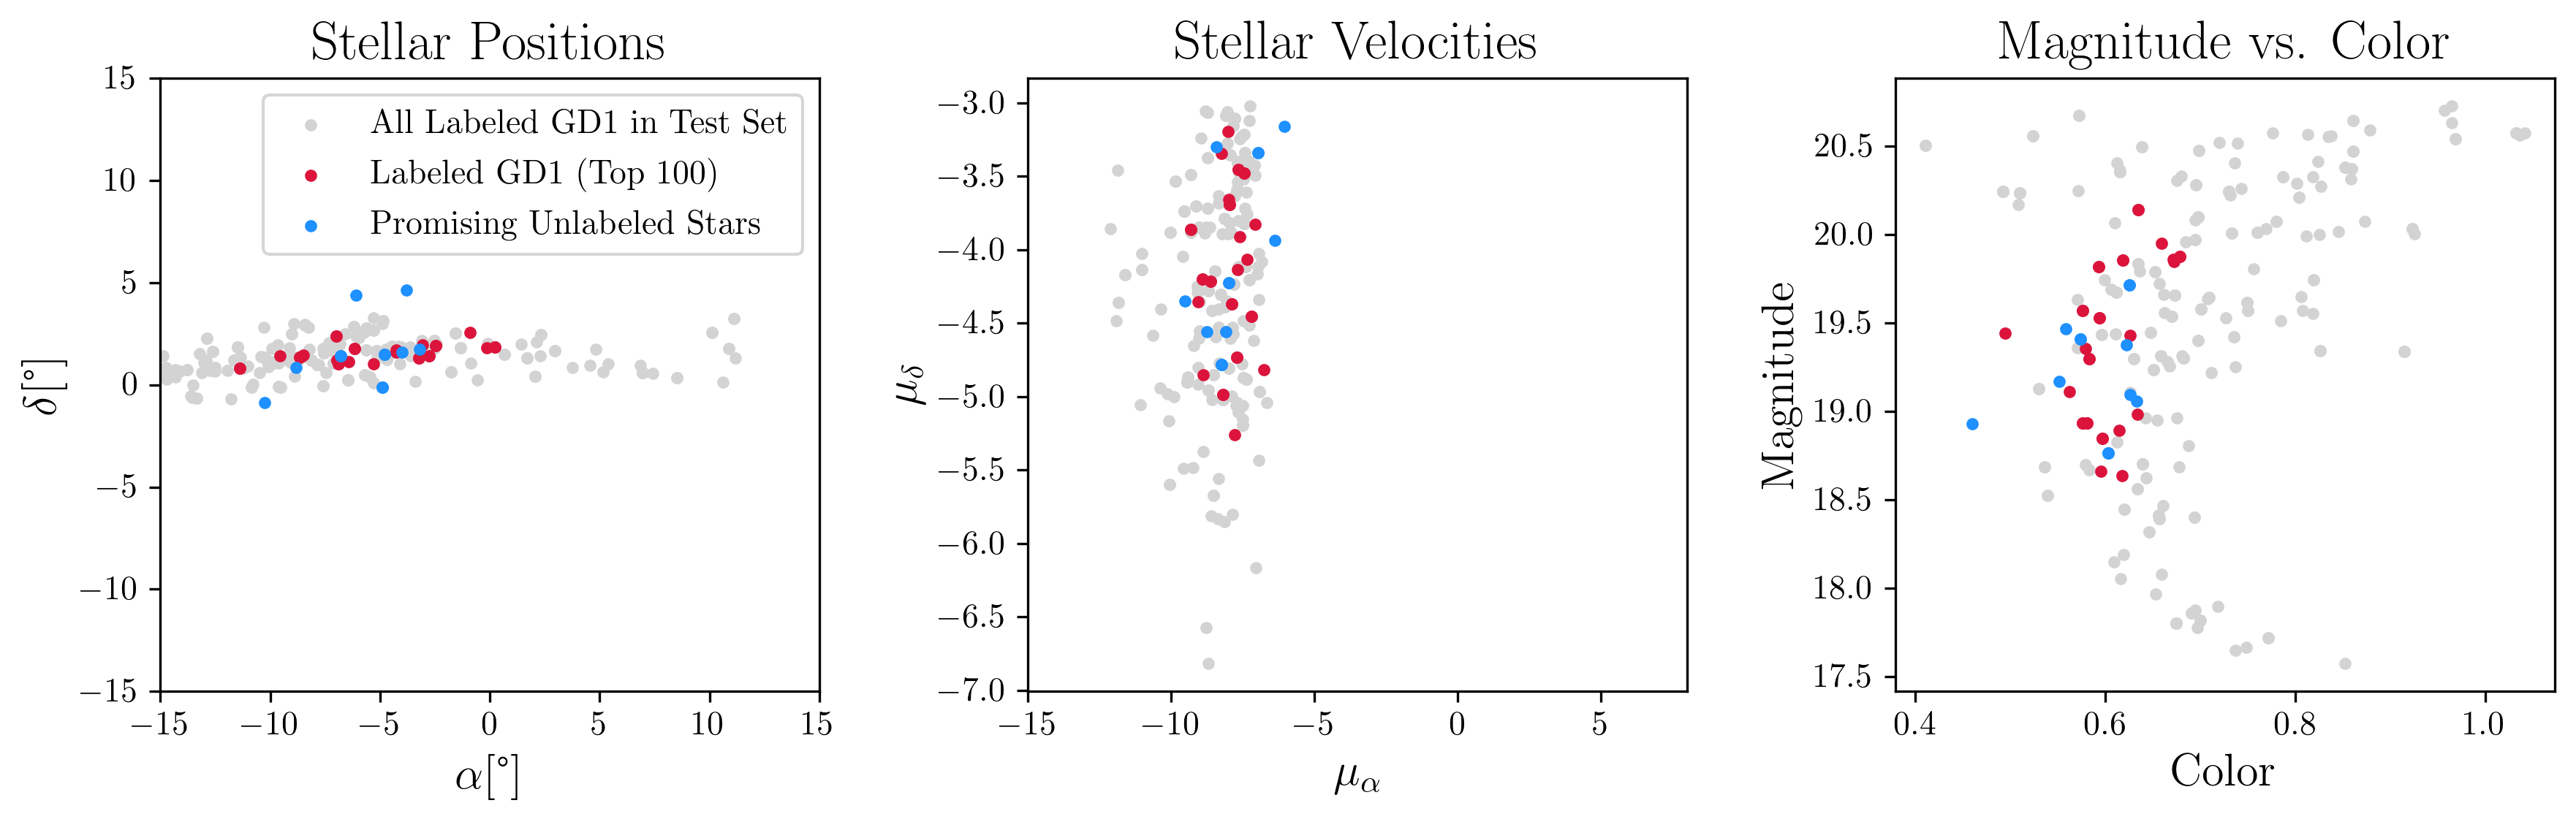

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True, dpi=300)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α, test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,8)
# ax.set_ylim(-7,-3)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
plt.savefig("../plots/promising_triptych.png")

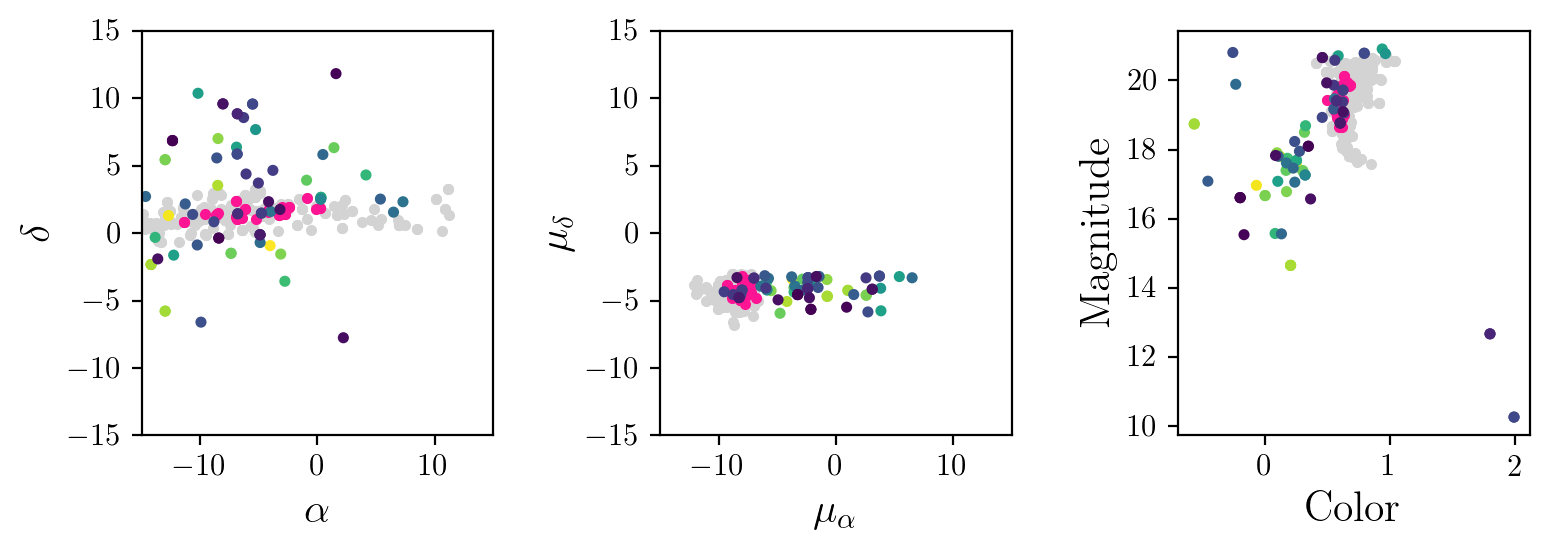

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,3), tight_layout=True, dpi=200)

ax = axs[0]
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\delta$");

ax = axs[1]
ax.scatter(test[test.stream].μ_α, test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="deeppink", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', c=unlabeled.nn_score, label="Promising Unlabeled Stars")
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");

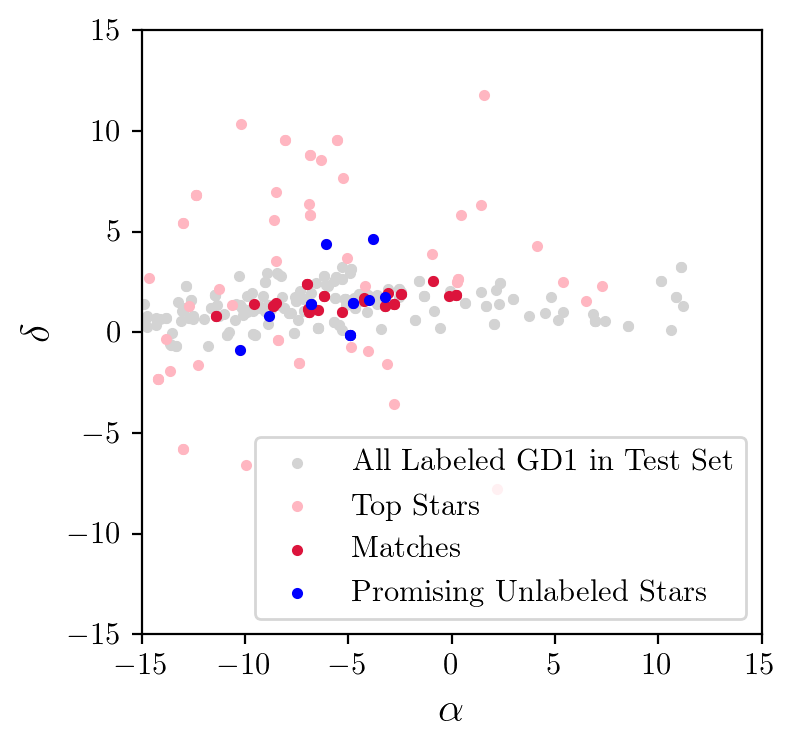

In [11]:
plt.figure(figsize=(4,4), dpi=200)
plt.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
plt.scatter(top_stars.α, top_stars.δ, marker='.', color="lightpink", label="Top Stars")
plt.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Matches")
plt.scatter(promising.α, promising.δ, marker='.', color="blue", label="Promising Unlabeled Stars")
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$");

What are the distances along the 5 dimensions to the true stream stars in the test set? 

In [51]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]

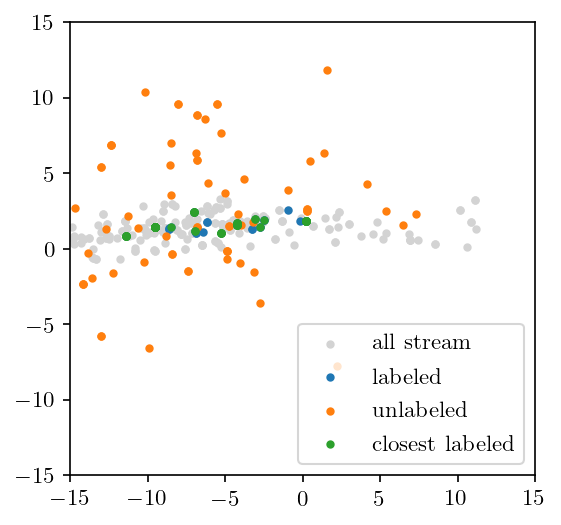

In [52]:
fig = plt.figure(figsize=(4,4), dpi=150)
plt.scatter(test[test.stream].α, test[test.stream].δ, color="lightgray", marker='.', label="all stream")
plt.scatter(labeled.α, labeled.δ, label="labeled", marker='.')
plt.scatter(unlabeled.α, unlabeled.δ, label="unlabeled", marker='.')
plt.scatter(closest_labeled.α, closest_labeled.δ, label="closest labeled", marker='.')
plt.legend()
plt.xlim(-15,15)
plt.ylim(-15,15);

In [53]:
closest_dists = distance_matrix(closest_labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
# closest_labeled = unlabeled.iloc[dists.argmin(axis=0)]

In [54]:
closest_labeled[cols]

,μ_α,δ,α,color,mag
1264250,-7.076258,1.585803,-4.257389,0.579575,19.356108
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521
744641,-8.188707,0.825206,-11.384846,0.580906,18.935190
744641,-8.188707,0.825206,-11.384846,0.580906,18.935190
...,...,...,...,...,...
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521
711976,-6.779801,1.412185,-9.549137,0.562590,19.111521


In [55]:
unlabeled[cols]

,μ_α,δ,α,color,mag
759764,-3.714790,-0.933281,-4.042286,0.253309,17.557947
606509,-1.570460,1.297870,-12.702335,-0.065334,16.964941
1064006,-4.170501,3.531929,-8.505116,0.123423,17.800142
972202,-0.728133,-2.331761,-14.190830,0.207507,14.649045
1120147,-0.728133,-2.331761,-14.190830,0.207507,14.649045
...,...,...,...,...,...
190017,-3.254366,6.847164,-12.362385,-0.194897,16.608688
376375,-3.254366,6.847164,-12.362385,-0.194897,16.608688
334061,-3.254366,6.847164,-12.362385,-0.194897,16.608688
1196325,-2.122281,-0.371861,-8.416187,0.349035,18.096661


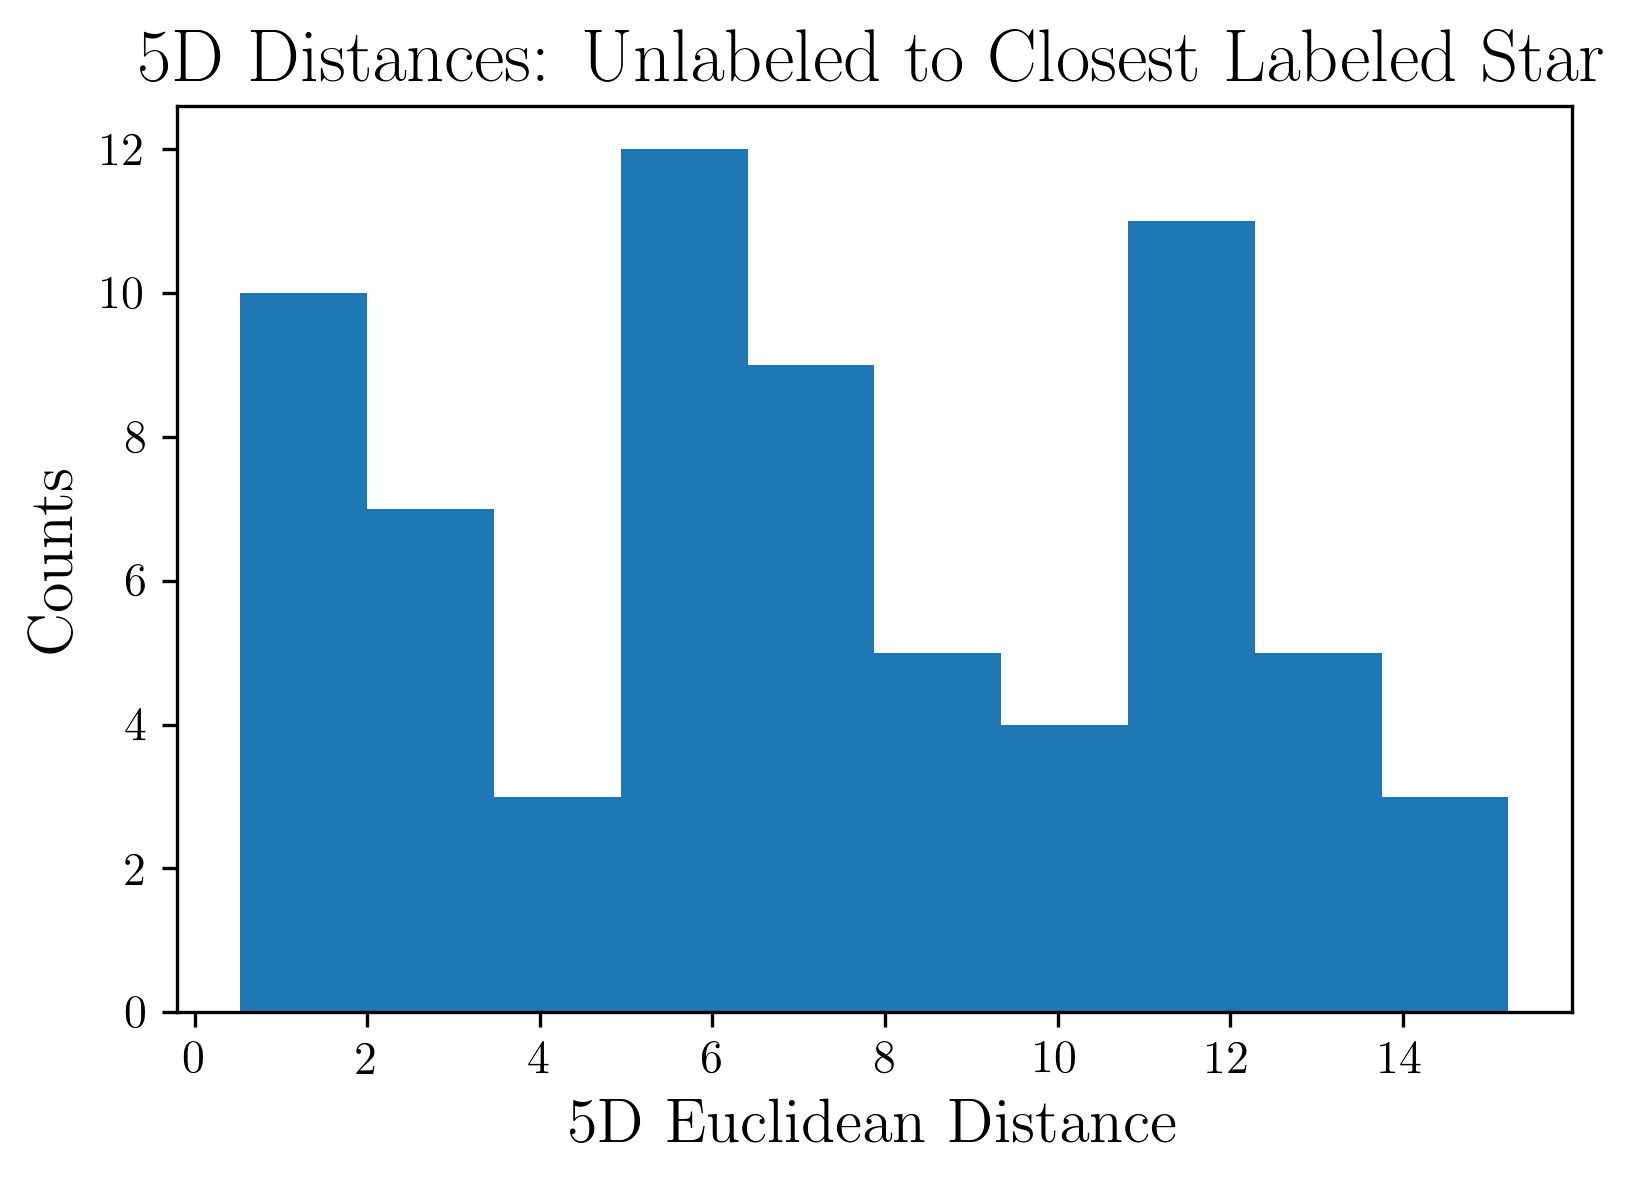

In [61]:
plt.figure(dpi=300)
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
plt.hist(distances, bins=10)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance")
plt.savefig("../plots/5d_distance.png")

In [62]:
unlabeled['5d_distance'] = distances

/tmp/ipykernel_14620/3539591142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled['5d_distance'] = distances


In [85]:
promising = unlabeled[(unlabeled['5d_distance'] < 5)]

In [86]:
len(promising)

20

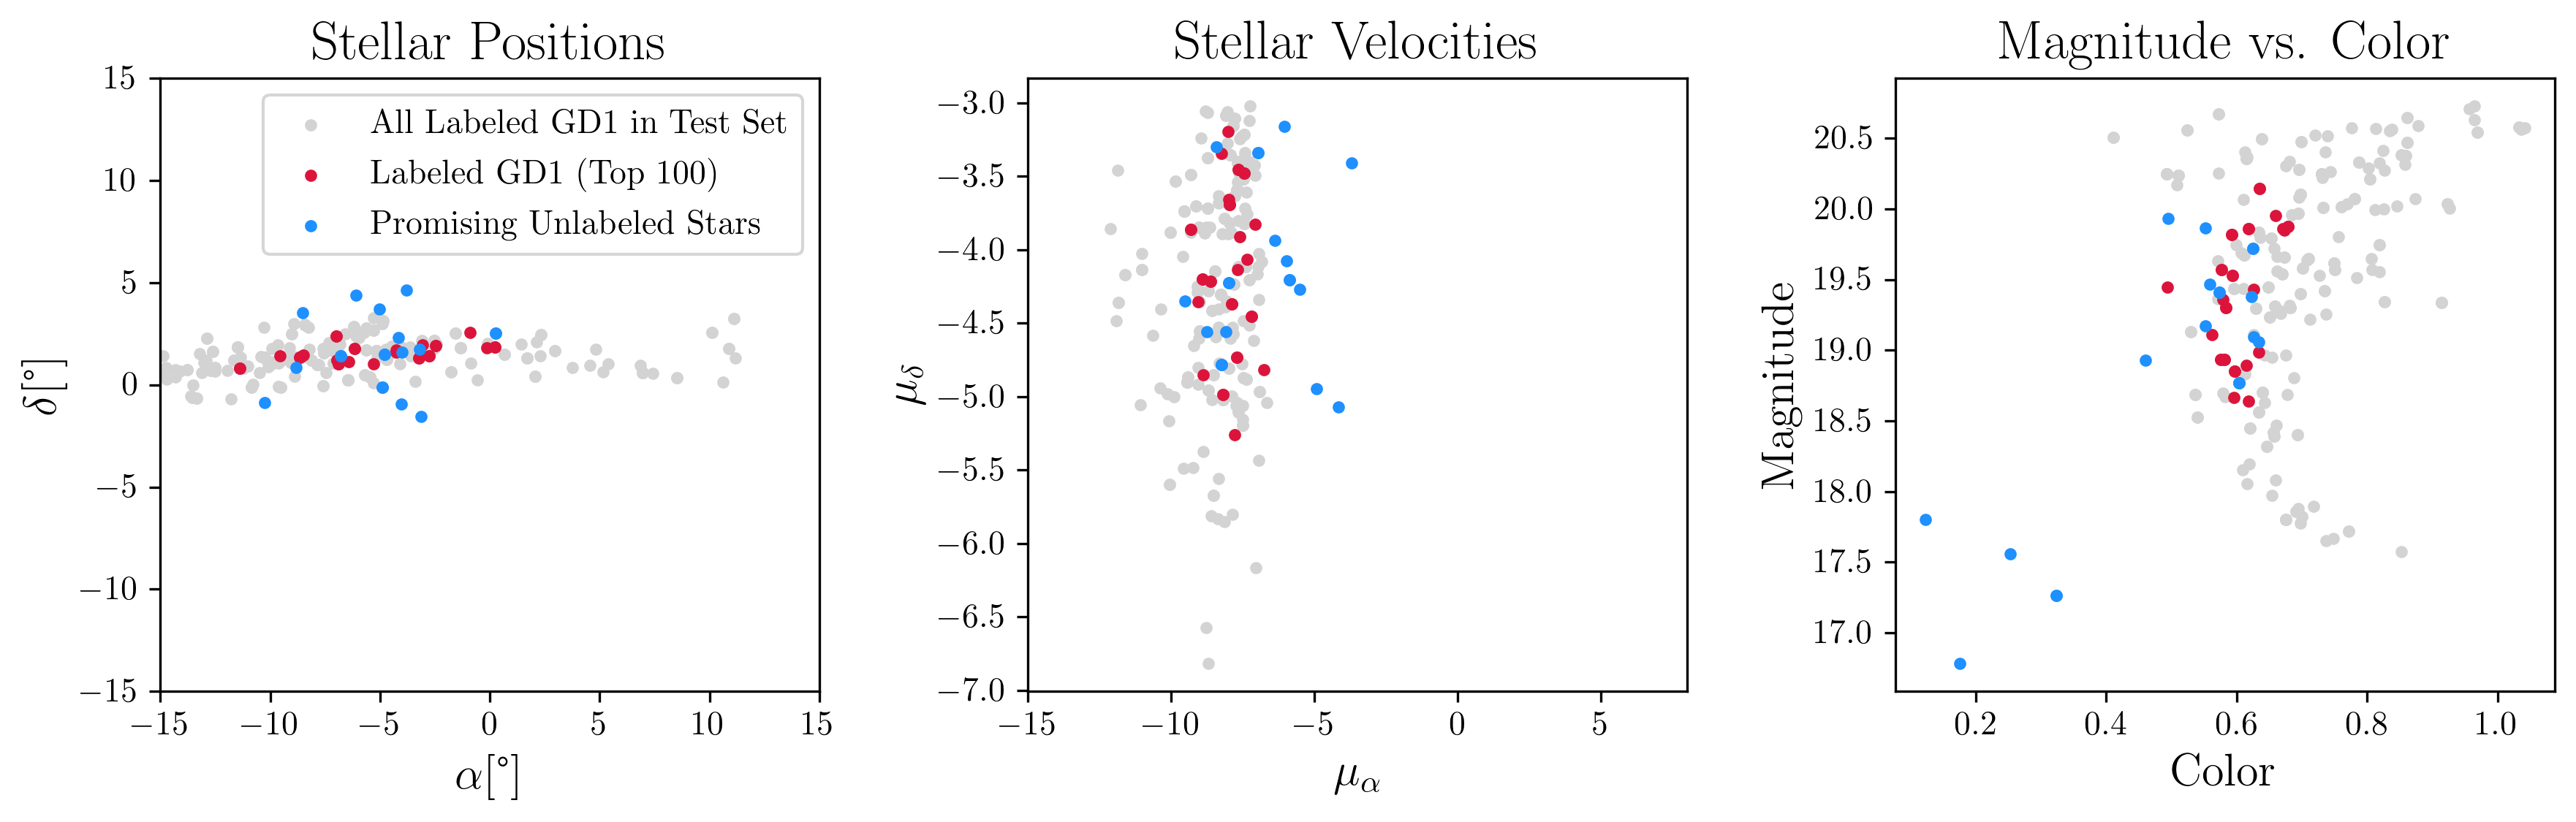

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True, dpi=300)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(test[test.stream].α, test[test.stream].δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(test[test.stream].μ_α, test[test.stream].μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlim(-15,8)
# ax.set_ylim(-7,-3)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(test[test.stream].color, test[test.stream].mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="Promising Unlabeled Stars")
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
plt.savefig("../plots/promising_triptych.png")

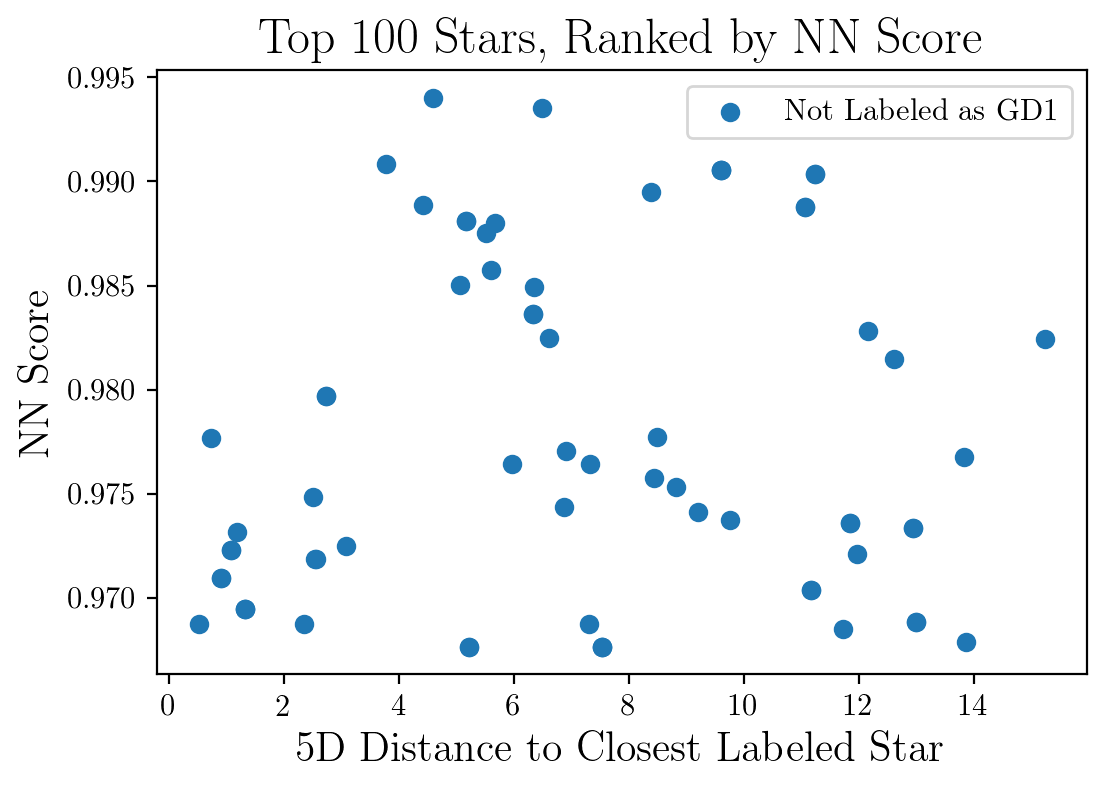

In [77]:
plt.figure(dpi=200)
# plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Labeled as GD1")
plt.scatter(unlabeled['5d_distance'],unlabeled['nn_score'], label="Not Labeled as GD1")
plt.xlabel("5D Distance to Closest Labeled Star")
plt.ylabel("NN Score")
plt.title("Top 100 Stars, Ranked by NN Score")
plt.legend()